## Reinforcement Learning: Project 1
## Multi-armed Bandits

The purpose of the first part of this project is to verify the results of running multiarmed bandits with Epsilon greedy iterations of 0 (greedy), 0.1 and 0.01. The result will be a line chart showing the average rewards distributions over 1000 steps for 2000 tasks. The second part of this project is to ingest a dataset and determine the same average reward distributions over 10,000 steps for 500 tasks.

In [34]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 


In [35]:
class bandit:
    def __init__(self, arms, type, steps):
        self.n = 0
        self.steps = steps
        self.arms = arms
        self.type = type
        self.mean_r = 0

        self.arm_n = np.zeros(arms)
        self.reward = np.zeros(steps)
        self.arm_r = np.zeros(arms)
        # unknown mean reward of a action
        self.meansdist = np.random.normal(0, 1, arms)
        # cumulative reward counter for ds
        #self.cumreward = 0
        self.cumrewardarm = np.zeros(arms)

    def run(self, ds): 
        for i in range(self.steps):
            # find random numbers and determine arm choice
            rn = np.random.rand()  
            if self.type == 0 and self.n == 0:
                act = np.random.choice(self.arms)       
                #print(f"first greedy action: {act}")    
            elif rn < self.type:
                act = np.random.choice(self.arms)
            else:
                act = np.argmax(self.arm_r)
                #print(f"subsequent greedy action: {act}")

            # increment counters
            self.n += 1
            self.arm_n[act] += 1
            
            # determine reward from Gaussian distribution with q*(a) as mean as varaiance 1
            if isinstance(ds, pd.DataFrame):
                reward = ds.iat[i, act]
            else:
                reward = np.random.normal(self.meansdist[act], 1)                

            # determine the mean reward and reward for the arm chosen
            self.mean_r = self.mean_r + (reward - self.mean_r) / self.n
            self.arm_r[act] = self.arm_r[act] + (reward - self.arm_r[act]) / self.arm_n[act]
        
            # update the reward array for each step
            self.reward[i] = self.mean_r

            # cumulative reward counter for ds
            #if isinstance(ds, pd.DataFrame):
            #self.cumreward += reward
            self.cumrewardarm[act] += reward

            '''
            if(type == 0):
                print("greedy reward")
                print(self.reward)
                print("greedy arm_r")
                print(self.arm_r)
            '''
    
    def reset(self):
        self.n = 0
        self.arm_n = np.zeros(self.arms)
        self.mean_r = 0
        self.reward = np.zeros(self.steps)
        self.arm_r = np.zeros(self.arms)
    

In [41]:
def executeLearning(arms, steps, tasks, ds):
    # establish the number of arms, steps and tasks
    arms = arms
    steps = steps
    tasks = tasks

    # set up the long-term reward arrays for each type
    greedy_r = np.zeros(steps)
    ep01_r = np.zeros(steps)
    ep1_r = np.zeros(steps)
    master_r = {}

    # task reward ds
    greedy_taskr = np.zeros(tasks)
    ep01_taskr = np.zeros(tasks)
    ep1_taskr = np.zeros(tasks)

    # hold max values for each arm over tasks
    greedy_cumrewardarm = np.zeros(arms)
    ep01_taskr_cumrewardarm = np.zeros(arms)
    ep1_taskr_cumrewardarm = np.zeros(arms)

    # list to hold cumrewardarm arrays
    armrewards = []

    for i in range(tasks):
        # initialize each type
        greedy = bandit(arms, 0, steps)
        e01 = bandit(arms, 0.01, steps)
        e1 = bandit(arms, 0.1, steps)

        # run learning action (pull arm) this is done the number of steps times
        greedy.run(ds)
        e01.run(ds)
        e1.run(ds)

        # deteremine the long-term rewards
        greedy_r = greedy_r + (greedy.reward - greedy_r) / (i + 1)
        ep01_r = ep01_r + (e01.reward - ep01_r) / (i + 1)
        ep1_r = ep1_r + (e1.reward - ep1_r) / (i + 1)

        #greedy_taskr[i] = greedy.cumreward
        #ep01_taskr[i] = e01.cumreward
        #ep1_taskr[i] = e1.cumreward
        #print(greedy.arm_r)
        #print("greedy cumre")
        #print(greedy_cumrewardarm)

        # determine max values for each arm in cumrewardarm
        for c in range(len(greedy.cumrewardarm)):
            if greedy.arm_r[c] > greedy_cumrewardarm[c]:
                greedy_cumrewardarm[c] = greedy.arm_r[c]

        #print("\n---")
        #print(greedy.arm_r)
        #print(greedy_cumrewardarm)

        # determine max values for each arm in cumrewardarm
        for c in range(len(e01.cumrewardarm)):
            if e01.arm_r[c] > ep01_taskr_cumrewardarm[c]:
                ep01_taskr_cumrewardarm[c] = e01.arm_r[c]

        # determine max values for each arm in cumrewardarm
        for c in range(len(e1.cumrewardarm)):
            if e1.arm_r[c] > ep1_taskr_cumrewardarm[c]:
                ep1_taskr_cumrewardarm[c] = e1.arm_r[c]
        
    # create multidimensional array to hold cumrewardarm vals
    armrewards.append(greedy_cumrewardarm)
    armrewards.append(ep01_taskr_cumrewardarm)
    armrewards.append(ep1_taskr_cumrewardarm)
    
    #max_r = np.amax(np.array([np.amax(greedy_taskr), np.amax(ep01_taskr), np.amax(ep1_taskr)]))

    master_r['greedy'] = greedy_r
    master_r['ep01'] = ep01_r
    master_r['ep1'] = ep1_r

    '''
    # draw the average reward output chart
    plt.figure(figsize=(10,8))
    plt.plot(greedy_r, label="greedy")
    plt.plot(ep01_r, label="epsilon=0.01")
    plt.plot(ep1_r, label="epsilon=0.1")
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.xlabel("Steps")
    plt.ylabel("Average Reward")
    if isinstance(ds, pd.DataFrame):
        plt.title("Ads Dataset Reward Chart with " + str(tasks) + " tasks")
    else:
        plt.title("Average Reward Chart with " + str(tasks) + " tasks")
    plt.show()
    '''

    greedy.reset()
    e01.reset()
    e1.reset()

    return master_r, armrewards



In [45]:
def determineMaxReward(armrewards):
    gmaindex = np.argmax(armrewards[0])
    print(f"\nThe arm with the maximum reward for the greedy selection was arm {gmaindex+1} with {round(armrewards[0][gmaindex],2)}")

    #print(armrewards[1])
    e01maindex = np.argmax(armrewards[1])
    print(f"The arm with the maximum reward for the epsilon 0.01 selection was arm {e01maindex+1} with {round(armrewards[1][e01maindex],2)}")

    #print(armrewards[2])
    e1maindex = np.argmax(armrewards[2])
    print(f"The arm with the maximum reward for the epsilon 0.1 selection was arm {e1maindex+1} with {round(armrewards[2][e1maindex],2)}")

    # Determine the max reward and step that produced it
    maxarms = [gmaindex+1, e01maindex+1, e1maindex+1]
    maxvals = [ round(armrewards[0][gmaindex],2), round(armrewards[1][e01maindex],2), round(armrewards[2][e1maindex],2)]
    print(maxarms)
    print(maxvals)
    maxval = max(maxvals)
    maxarm = maxarms[maxvals.index(maxval)]

    return maxval, maxarm

In [46]:
def drawAvgChart(stepsarr, rewards):
    #print(rewards[10])
    fig,axs = plt.subplots(2,2, figsize=(10,10), constrained_layout=True)
    fig.suptitle('Average Rewards over 2000 Tasks')
    axs[0, 0].plot(rewards[stepsarr[0]]['greedy'])
    axs[0, 0].plot(rewards[stepsarr[0]]['ep01'])
    axs[0, 0].plot(rewards[stepsarr[0]]['ep1'])
    axs[0, 0].set_title(f'{stepsarr[0]} Steps')

    axs[0, 1].plot(rewards[stepsarr[1]]['greedy'])
    axs[0, 1].plot(rewards[stepsarr[1]]['ep01'])
    axs[0, 1].plot(rewards[stepsarr[1]]['ep1'])
    axs[0, 1].set_title(f'{stepsarr[1]} Steps')

    axs[1, 0].plot(rewards[stepsarr[2]]['greedy'])
    axs[1, 0].plot(rewards[stepsarr[2]]['ep01'])
    axs[1, 0].plot(rewards[stepsarr[2]]['ep1'])
    axs[1, 0].set_title(f'{stepsarr[2]} Steps')

    axs[1, 1].plot(rewards[stepsarr[3]]['greedy'])
    axs[1, 1].plot(rewards[stepsarr[3]]['ep01'])
    axs[1, 1].plot(rewards[stepsarr[3]]['ep1'])
    axs[1, 1].set_title(f'{stepsarr[3]} Steps')


    for ax in axs.flat:
        ax.set(xlabel='Steps', ylabel='Average Reward')

    #for ax in axs.flat:
    #    ax.label_outer()
    '''
    plt.figure(figsize=(10,8))
    plt.plot(rewards[10]['greedy'], label="greedy")
    plt.plot(ep01_r, label="epsilon=0.01")
    plt.plot(ep1_r, label="epsilon=0.1")
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.xlabel("Steps")
    plt.ylabel("Average Reward")
    if isinstance(ds, pd.DataFrame):
        plt.title("Ads Dataset Reward Chart with " + str(tasks) + " tasks")
    else:
        plt.title("Average Reward Chart with " + str(tasks) + " tasks")
    plt.show()
    '''


The arm with the maximum reward for the greedy selection was arm 10 with 3.58
The arm with the maximum reward for the epsilon 0.01 selection was arm 7 with 3.62
The arm with the maximum reward for the epsilon 0.1 selection was arm 7 with 3.46
[10, 7, 7]
[3.58, 3.62, 3.46]
Max reward of 3.62 was produced by Arm 7

The arm with the maximum reward for the greedy selection was arm 9 with 4.05
The arm with the maximum reward for the epsilon 0.01 selection was arm 1 with 3.92
The arm with the maximum reward for the epsilon 0.1 selection was arm 4 with 4.17
[9, 1, 4]
[4.05, 3.92, 4.17]
Max reward of 4.17 was produced by Arm 4

The arm with the maximum reward for the greedy selection was arm 2 with 3.53
The arm with the maximum reward for the epsilon 0.01 selection was arm 5 with 4.21
The arm with the maximum reward for the epsilon 0.1 selection was arm 1 with 3.72
[2, 5, 1]
[3.53, 4.21, 3.72]
Max reward of 4.21 was produced by Arm 5

The arm with the maximum reward for the greedy selection w

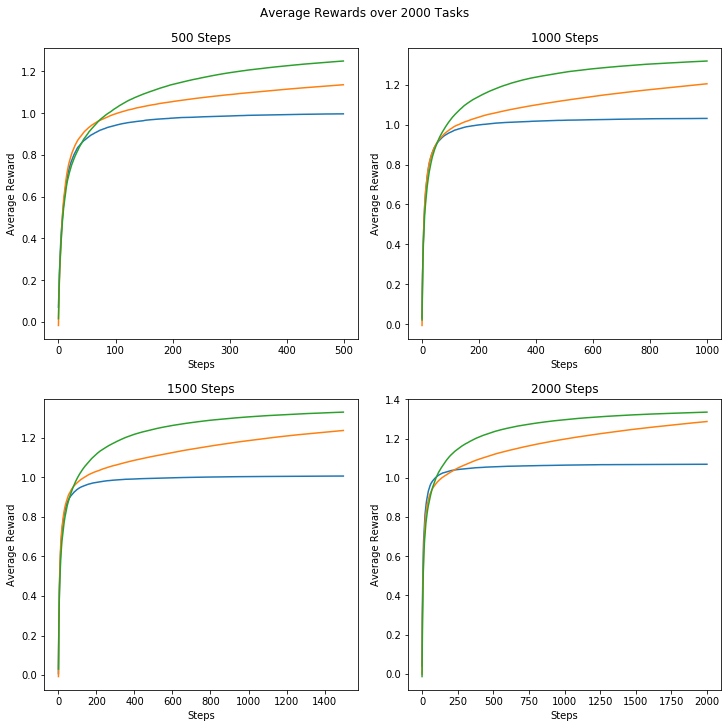

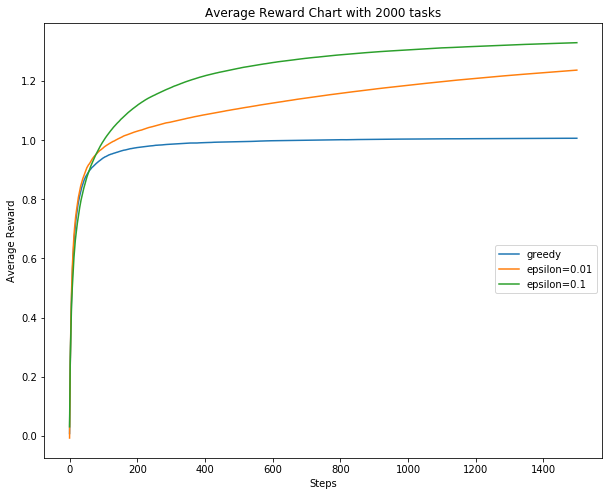

In [50]:
# Gaussian distribution with 10-Arm Testbed
rtasks = 2000
steps = [500, 1000, 1500, 2000]
chartlist = {}
maxlist = {}
for s in steps:
    master_r, armrewards = executeLearning(10, s, rtasks, None)
    chartlist[s] = master_r
    maxval, maxarm = determineMaxReward(armrewards)
    print(f"Max reward of {maxval} was produced by Arm {maxarm}")
    maxlist[s] = [maxval, maxarm]

#print(maxlist)


# Determine max reward
result = maxlist[steps[0]][0]
for k, v in maxlist.items():
    if v[0] > result:
        result = v[0]
        resultarm = v[1]
        resultsteps = k

print(resultsteps)


print(maxlist)

drawAvgChart(steps,chartlist)

print(f"Over {resultsteps} steps, arm number {resultarm} produced a maximum reward of {result}")


plt.figure(figsize=(10,8))
plt.plot(chartlist[resultsteps]['greedy'], label="greedy")
plt.plot(chartlist[resultsteps]['ep01'], label="epsilon=0.01")
plt.plot(chartlist[resultsteps]['ep1'], label="epsilon=0.1")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.title("Average Reward Chart with " + str(rtasks) + " tasks")
plt.show()





The arm with the maximum reward for the greedy selection was arm 5 with 0.27
The arm with the maximum reward for the epsilon 0.01 selection was arm 8 with 0.38
The arm with the maximum reward for the epsilon 0.1 selection was arm 5 with 0.34
[5, 8, 5]
[0.27, 0.38, 0.34]
Max reward of 0.38 was produced by Arm 8

The arm with the maximum reward for the greedy selection was arm 5 with 0.27
The arm with the maximum reward for the epsilon 0.01 selection was arm 5 with 0.33
The arm with the maximum reward for the epsilon 0.1 selection was arm 5 with 0.3
[5, 5, 5]
[0.27, 0.33, 0.3]
Max reward of 0.33 was produced by Arm 5

The arm with the maximum reward for the greedy selection was arm 5 with 0.27
The arm with the maximum reward for the epsilon 0.01 selection was arm 2 with 0.33
The arm with the maximum reward for the epsilon 0.1 selection was arm 5 with 0.29
[5, 2, 5]
[0.27, 0.33, 0.29]
Max reward of 0.33 was produced by Arm 2

The arm with the maximum reward for the greedy selection was a

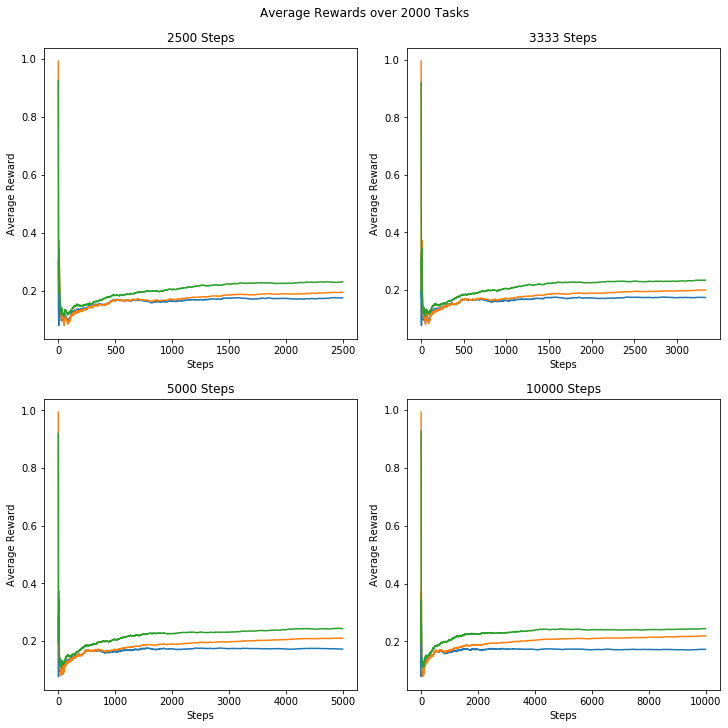

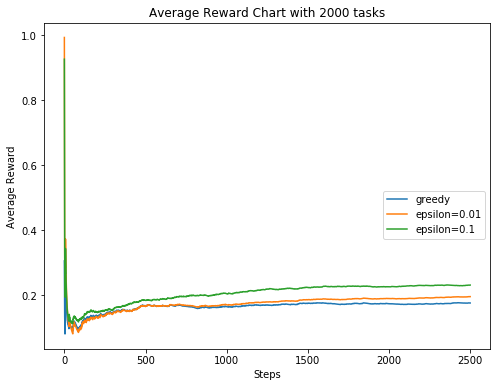

In [51]:
# Gaussian distribution for ads dataset
ads = pd.read_csv('Ads_Optimisation.csv')
rtasks = 2000
#steps = [10, 11, 12, 13]
steps = [int(len(ads.index)/4), int(len(ads.index)/3), int(len(ads.index)/2), len(ads.index)]
chartlist = {}
maxlist = {}
for s in steps:
    master_r, armrewards = executeLearning(10, s, rtasks, ads)
    chartlist[s] = master_r
    maxval, maxarm = determineMaxReward(armrewards)
    print(f"Max reward of {maxval} was produced by Arm {maxarm}")
    maxlist[s] = [maxval, maxarm]

# Determine max reward
result = maxlist[steps[0]][0]
resultarm = maxlist[steps[0]][1]
resultsteps = steps[0]
for k, v in maxlist.items():
    if v[0] > result:
        result = v[0]
        resultarm = v[1]
        resultsteps = k


#print(maxlist)
#print(chartlist)

drawAvgChart(steps,chartlist)

print(f"Over {resultsteps} steps, arm number {resultarm} produced a maximum reward of {result}")


plt.figure(figsize=(8, 6))
plt.plot(chartlist[resultsteps]['greedy'], label="greedy")
plt.plot(chartlist[resultsteps]['ep01'], label="epsilon=0.01")
plt.plot(chartlist[resultsteps]['ep1'], label="epsilon=0.1")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.title("Average Reward Chart with " + str(rtasks) + " tasks")
plt.show()



### Analysis for Average Reward for Randomized rewards along Gaussian distribution

In [ ]:
# Ads dataset
ads = pd.read_csv('Ads_Optimisation.csv')
atasks = 100
master_r, armrewards = executeLearning(len(ads.columns), len(ads.index), atasks, ads)
#print(f"\nThe maximum reward possible for this ads dataset with {atasks} tasks is {max_r}")

adsmaxval, adsmaxarm = determineMaxReward(armrewards)
print(f"Max reward of {adsmaxval} was produced by Arm {adsmaxarm}")



## Analysis for Average Reward for the Ads dataset